# Retail Customer Analysis Summative Lab
## Understanding Customer Behavior Across Store Locations

### Introduction

This summative lab bridges the concepts and techniques learned throughout the course with their practical application to a real-world industry scenario. You will step into the role of a junior data analyst for a retail company and apply your skills to evaluate customer behavior, satisfaction, and promotional impacts. By following the outlined process, you will gain experience in experimental design, statistical testing, and actionable decision-making.

Your task is not only to conduct the analysis but also to reflect on how these techniques help solve real-world problems that businesses face daily.

By completing this lab, you will have:
- Practiced designing and executing statistical analyses in a real-world scenario.
- Reinforced your understanding of test selection and assumptions.
- Applied statistical results to business decision-making.
- Developed skills in communicating insights effectively through visualizations and reports.

### Business Scenario Questions:
Imagine you are a junior data analyst working for a retail company that operates stores in three distinct regions: City Center, Suburb, and Rural. Your manager has tasked you with analyzing customer behavior and preferences across these locations. The goal is to help the company answer two key questions:
1. Do customer spending patterns, satisfaction levels, and product preferences differ across store locations?
2. Do promotional periods result in significantly higher spending compared to non-promotional periods?

Spending Across Location:

- Business-relevant MDE: Absolute difference in spending of 15% or more
- Justification: This represents enough of a difference to warrant location-specific strategies (inventory, staffing, etc.)


Ratings Across Locations:

- Business-relevant MDE: 1.0 point difference between locations
- Justification: On a 10-point scale, a one point difference is noticeable and actionable for customer service improvements

Promotional Spending:

- Business-relevant MDE: A $15 increase from non-promotional periods
- Justification: Promotional costs typically reduce margins by ~15-20%. Need at least 25% increase in spending to justify promotional costs. This aligns with industry standards for promotional ROI

Your task involves designing and conducting an analysis using the provided dataset to derive actionable insights. You will apply statistical concepts and techniques such as experimental design, test selection, hypothesis testing, and result interpretation. This process mimics real-world industry scenarios where junior analysts evaluate business performance using data.

The data focuses on four variables:
- Amount spent by customers (in dollars)
- Customer satisfaction ratings (scale of 1 to 10)
- Product category preferences (Electronics, Clothing, Groceries)
- Purchase type (Promotional vs. Non-Promotional)

Your analysis will inform decision-making around marketing strategies, store operations, and promotional campaigns.

### Setup

In this cell, import all the libraries you'll need for your analysis. Consider which libraries you'll need for:
- Data manipulation
- Statistical analysis
- Data visualization

In [57]:
%matplotlib inline

In [58]:
# Import relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import pingouin as pg
import seaborn as sns
import scikit_posthocs as sp
from ydata_profiling import ProfileReport
from scipy.stats import shapiro, levene
from itertools import combinations
from matplotlib.colors import LinearSegmentedColormap

### Part 1: Experimental Design

#### 1.1 Hypothesis Formulation

For each of the following analyses, state your null and alternative hypotheses in both statistical and plain language:

**Statistical**
1. Spending across store locations

   a. Null hypothesis: All locations' mean spending are equal.

   b. Alternative: There is at least one pair of locations with different mean spending.

2. Customer satisfaction across locations

   a. Null hypothesis: All locations' median satisfaction scores are equal.

   b. Alternative: There is at least one pair of locations with different median satisfaction scores.

3. Promotional vs non-promotional spending

   a. Null hypothesis: Mean promotional and non-promotional spending are equal.

   b. Alternative: Mean promotional spending is higher than mean non-promotional spending.

4. Product category preferences across locations

   a. Null hypothesis: All locations have the same product category distribution.

   b. Alternative: There is at least one pair of locations with different product category distributions.

**Plainer**
1. Spending across store locations

   a. Null hypothesis: The average amount customers spend is the same at all three store locations (City Center, Suburb, and Rural).

   b. Alternative: The average amount customers spend is different at least for one of the store locations.

2. Customer satisfaction across locations

   a. Null hypothesis: Typical customer satisfaction levels are the same across all three store locations.

   b. Alternative: Typical customer satisfaction levels differ across locations.

3. Promotional vs non-promotional spending

   a. Null hypothesis: The average amount spent on purchases made with a promotion is the same as the average amount spent on purchases made without a promotion.

   b. Alternative: On average, customers spend more money when they make a purchase using a promotion compared to when they don't.

4. Product category preferences across locations

   a. Null hypothesis: The popularity of different product categories (like Electronics, Groceries, Clothing) is the same regardless of the store location.

   b. Alternative: The types of products customers prefer to buy differ depending on the store location.

**Reflective Question: Explain the concept of Minimum Detectable Effect (MDE) and why it is important.**

MDE is the minimum effect that our test can detect based on its statistical power. It is an important part of experiment design to inform our decisions about sample size. If we want to detect a very small change (like a 2% relative increase), because even a small change may be relevant to our business, we will need a much larger sample. Conversely, if we only care about detecting a large change, such as a 20-30% relative increase, we do not need as large of a sample. This is also influenced by the desired degree of confidence in our results (alpha).

### Part 2: Data Exploration

#### 2.1 Load and Examine the Dataset

Load the dataset and perform initial data quality checks:
- Check for missing values
- Examine data types
- Look for inconsistencies
- Generate summary statistics

In [59]:
# Load Data
data = pd.read_csv("retail_store_customer_data.csv")
data["Product_Category"].value_counts()

# Initial EDA - Create new cells as needed
#data.head()
profile = ProfileReport(data, minimal=True)
profile.to_file("retail_data_eda_report.html") 
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 714.46it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#### 2.2 Data Visualization

Create visualizations to understand the distribution of key variables:
- Spending patterns across locations
- Satisfaction ratings distribution
- Product category preferences
- Promotional vs non-promotional spending

In [86]:
# Define colors for "visual language"

location_palette = sns.color_palette("Set1")
location_colors = {
    "Rural": location_palette[0],
    "City Center": location_palette[1],
    "Suburb": location_palette[2]
}

# Define the colormap: red to green for ratings
colors = [(1, 0, 0), (0, 1, 0)]  # Red at index 0, Green at index 1
cmap_name = 'red_to_green'
ratings_cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

# Colors for product categories
product_colors = ["purple", "orange", "lightgrey"] # Electronics, Groceries, Clothing

# Define the desired order of locations
location_order = ["Rural", "City Center", "Suburb"]

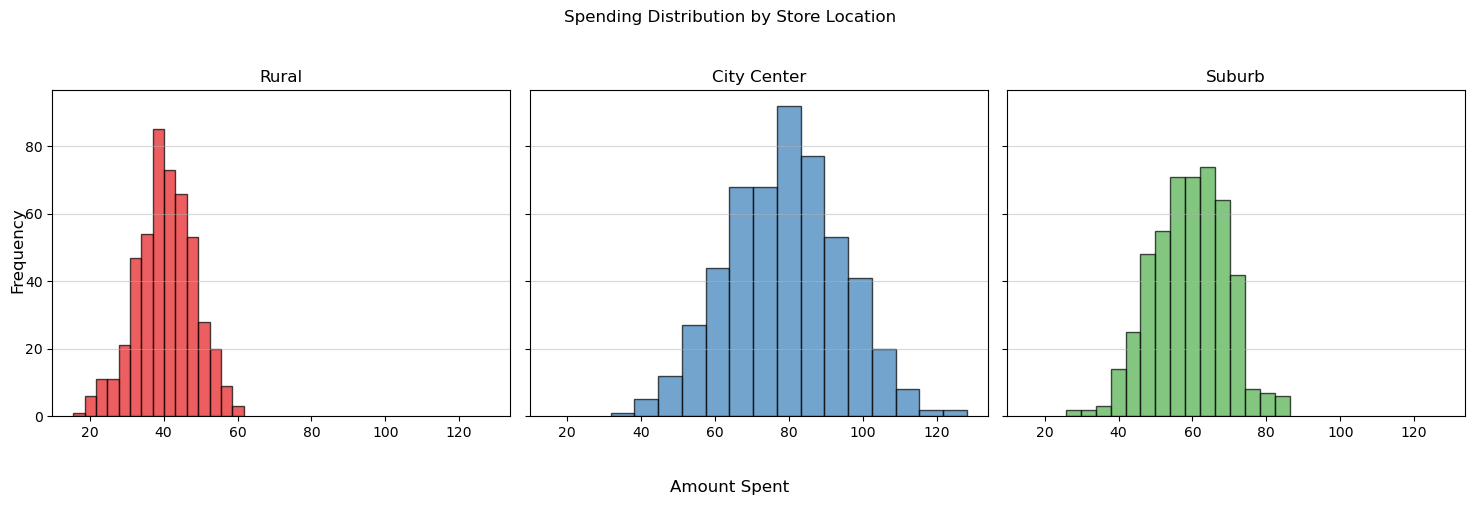

In [61]:
# Asked Gemini to create histograms with shared axes labels because my original was visually repetitive and not scaled

locations = data['Store_Location'].unique()

# Create figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

for i, location in enumerate(locations):
    location_data = data[data['Store_Location'] == location]['Amount_Spent']
    color = location_colors[location]  # Get the color for this location
    axes[i].hist(location_data, bins=15, edgecolor='black', alpha=0.7, color=color)
    axes[i].set_title(f'{location}')
    axes[i].grid(axis='y', alpha=0.5)

# Set common labels for the entire figure
fig.supxlabel('Amount Spent')
fig.supylabel('Frequency')
fig.suptitle('Spending Distribution by Store Location')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for suptitle
plt.show()

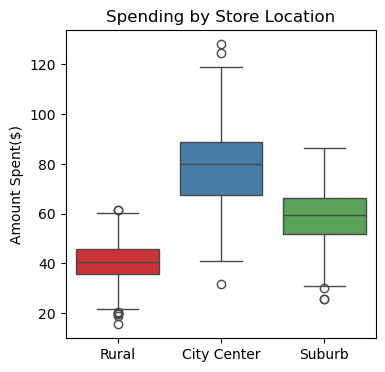

In [89]:
# Show as a boxplot instead.
plt.figure(figsize=(4, 4))
sns.boxplot(x="Store_Location", hue="Store_Location", y="Amount_Spent", data=data, palette="Set1", legend=False)

plt.ylabel("Amount Spent($)")
plt.title("Spending by Store Location")
plt.xlabel("")

plt.show()

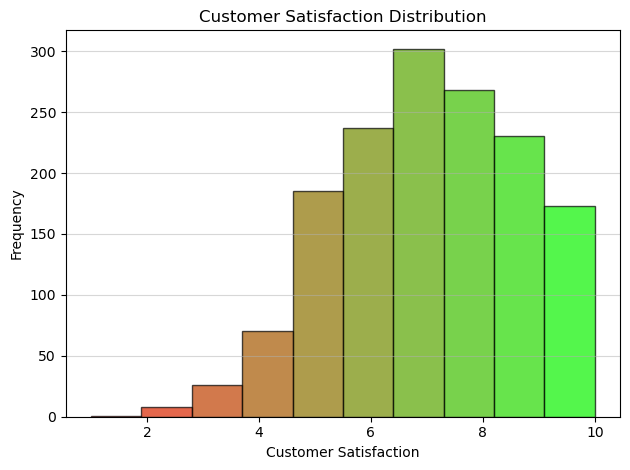

In [63]:
# Asked Gemini for a color gradient histogram

# Customer satisfaction data
satisfaction = data['Customer_Satisfaction']

# Create the histogram
fig, ax = plt.subplots() # Create a figure and an axes object
n, bins, patches = ax.hist(satisfaction, bins=10, edgecolor='black', alpha=0.7)

# Normalize bin centers to the range [0, 1] for the colormap
bin_centers = 0.5 * (bins[:-1] + bins[1:])
norm = plt.Normalize(vmin=1, vmax=10)
scalarMap = plt.cm.ScalarMappable(norm=norm, cmap=ratings_cm)
scalarMap.set_array([]) # Important: Need to set an array for the mappable

# Color the bars based on the normalized bin centers
for i, patch in enumerate(patches):
    colorVal = scalarMap.to_rgba(bin_centers[i])
    patch.set_facecolor(colorVal)

ax.set_title('Customer Satisfaction Distribution')
ax.set_xlabel('Customer Satisfaction')
ax.set_ylabel('Frequency')
ax.grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

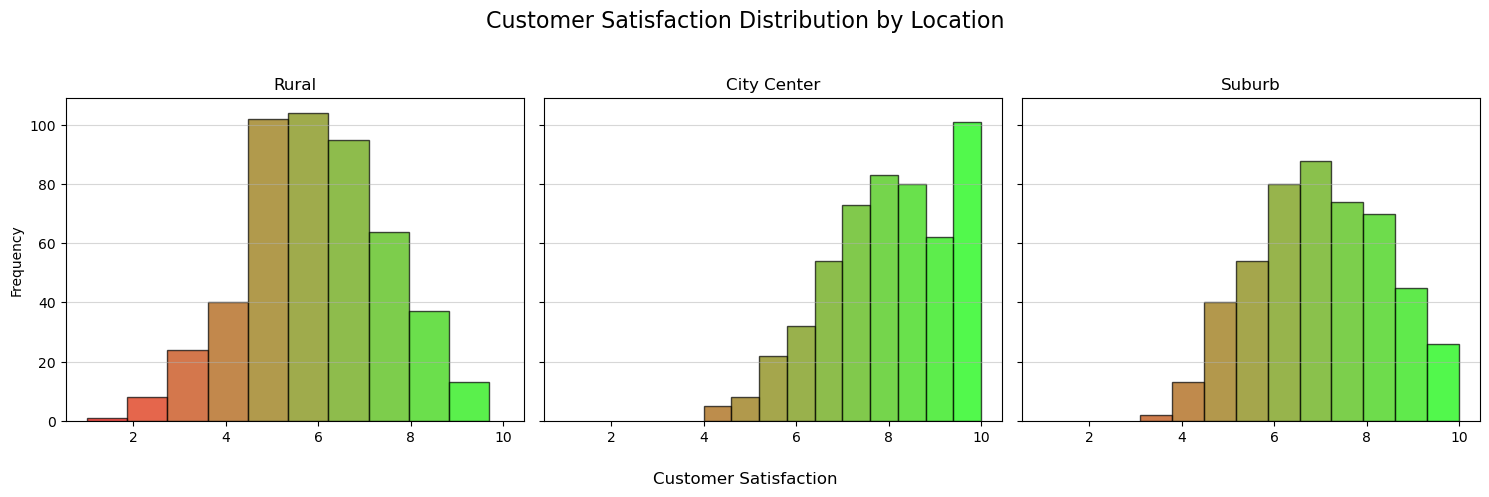

In [64]:
# Define locations
locations = data['Store_Location'].unique()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle('Customer Satisfaction Distribution by Location', fontsize=16)

# Iterate through locations and create histograms
for i, location in enumerate(locations):
    location_satisfaction = data[data['Store_Location'] == location]['Customer_Satisfaction']
    n, bins, patches = axes[i].hist(location_satisfaction, bins=10, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{location}')
    axes[i].grid(axis='y', alpha=0.5)

    # Normalize bin centers for the colormap
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    norm = plt.Normalize(vmin=1, vmax=10)
    scalarMap = plt.cm.ScalarMappable(norm=norm, cmap=ratings_cm)
    scalarMap.set_array([])  # Important: Need to set an array for the mappable

    # Color the bars based on the normalized bin centers
    for j, patch in enumerate(patches):
        colorVal = scalarMap.to_rgba(bin_centers[j])
        patch.set_facecolor(colorVal)

# Set y-axis label for the first subplot
axes[0].set_ylabel('Frequency')

# Set a shared x-axis label
fig.text(0.5, 0.04, 'Customer Satisfaction', ha='center', va='center', fontsize=12)

plt.tight_layout(rect=[0, 0.08, 1, 0.95]) # Adjust layout to make space for suptitle and xlabel
plt.show()

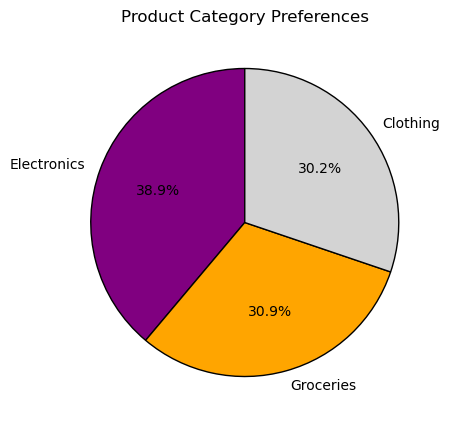

In [65]:
category_counts = data["Product_Category"].value_counts()
categories = category_counts.index.tolist()
counts = category_counts.values.tolist()

plt.figure(figsize=(5, 5))
plt.pie(counts, labels=categories, autopct="%1.1f%%", startangle=90, wedgeprops={"edgecolor": "black"}, colors=product_colors)
plt.title("Product Category Preferences")
plt.show()

In [66]:
promo_counts = data["Purchase_Type"].value_counts(normalize=True).mul(100).round(2)
promo_means = data.groupby("Purchase_Type")["Amount_Spent"].mean().round(2)

promo_summary = pd.DataFrame({
    "Frequency (%)": promo_counts,
    "Average Spending ($)": promo_means
})

print("Promotional vs. Non-Promotional Purchase Summary:")
promo_summary

Promotional vs. Non-Promotional Purchase Summary:


,Frequency (%),Average Spending ($)
Purchase_Type,,
Non-Promotional,40.8,59.77
Promotional,59.2,60.02


##### Promotional Spending Visualization

We were asked to create a visualization for each category. I feel that the table above best communicates the information. I was unable to find a visual format that could effectively communicate such a small difference.

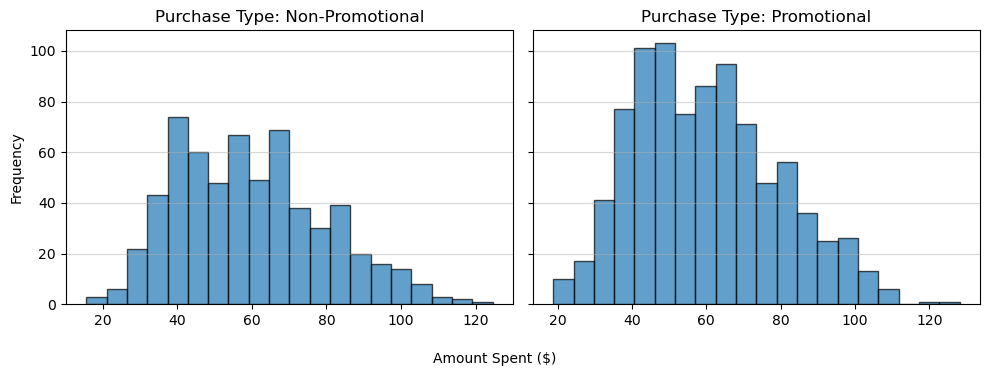

In [67]:
# --- Visualization ---
purchase_types = data["Purchase_Type"].unique()
num_plots = len(purchase_types)

fig, axes = plt.subplots(1, num_plots, figsize=(10, 4), sharey=True) # Share y-axis

for i, purchase_type in enumerate(purchase_types):
    spending_data = data[data["Purchase_Type"] == purchase_type]["Amount_Spent"]
    ax = axes[i] # Select the current subplot
    ax.hist(spending_data, bins=20, edgecolor="black", alpha=0.7)
    ax.set_title(f"Purchase Type: {purchase_type}")
    ax.grid(axis="y", alpha=0.5)

    if i == 0:
        ax.set_ylabel("Frequency")
    else:
        ax.set_ylabel("") # Remove y-axis label from the right plot

# Set a shared x-axis label
fig.text(0.5, 0.04, "Amount Spent ($)", ha="center", va="center")

plt.tight_layout(rect=[0, 0.08, 1, 0.95]) # Adjust layout to make space for xlabel
plt.show()

#### 2.3 Test Assumptions

Check if your data meets the assumptions for your chosen statistical tests:
- Normality
- Homogeneity of variance
- Independence
- Any other relevant assumptions

##### Normality Tests

In [68]:
# 1. Spending Across Store Locations (check normality per location)
print("--- Shapiro-Wilk Test for Spending Normality ---")
for location in data["Store_Location"].unique():
    spending_data = data[data["Store_Location"] == location]["Amount_Spent"]
    stat, p = shapiro(spending_data)
    print(f"Location: {location}")
    print(f"  Shapiro-Wilk Statistic: {stat:.3f}")
    print(f"  P-value: {p:.3f}")
    if p > 0.05:
        print("  Normally distributed")
    else:
        print("  Not normally distributed")
    print("-" * 30)

--- Shapiro-Wilk Test for Spending Normality ---
Location: Rural
  Shapiro-Wilk Statistic: 0.996
  P-value: 0.259
  Normally distributed
------------------------------
Location: City Center
  Shapiro-Wilk Statistic: 0.998
  P-value: 0.754
  Normally distributed
------------------------------
Location: Suburb
  Shapiro-Wilk Statistic: 0.994
  P-value: 0.050
  Normally distributed
------------------------------


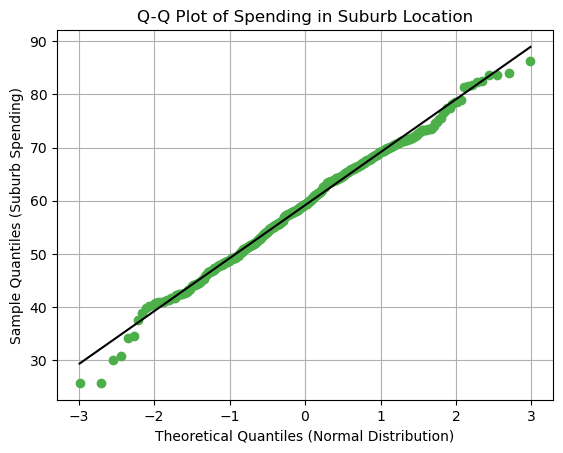

In [69]:
# Get spending data for the Suburb location
suburb_spending = data[data["Store_Location"] == "Suburb"]["Amount_Spent"]

# Create the Q-Q plot
stats.probplot(suburb_spending, dist="norm", plot=plt)

# Get the Seaborn green color for Suburb
suburb_color = sns.color_palette("Set1")[2]

# Change the color of the Q-Q plot dots
plt.gca().get_children()[0].set_color(suburb_color)  # Set the color of the points
plt.gca().get_children()[0].set_markerfacecolor(suburb_color) # ensure the fill is also green
plt.gca().get_children()[1].set_color("black")

plt.title("Q-Q Plot of Spending in Suburb Location")
plt.xlabel("Theoretical Quantiles (Normal Distribution)")
plt.ylabel("Sample Quantiles (Suburb Spending)")
plt.grid(True)
plt.show()

In [70]:
# 2. Customer Satisfaction Across Locations (check normality per location)
print("Shapiro-Wilk Test for Customer Satisfaction Normality")
for location in data["Store_Location"].unique():
    satisfaction_data = data[data["Store_Location"] == location]["Customer_Satisfaction"]
    stat, p = shapiro(satisfaction_data)
    print(f"Location: {location}")
    print(f"  Shapiro-Wilk Statistic: {stat:.3f}")
    print(f"  P-value: {p:.3f}")
    if p > 0.05:
        print("  Normally distributed")
    else:
        print("  Not normally distributed")
    print("-" * 30)

Shapiro-Wilk Test for Customer Satisfaction Normality
Location: Rural
  Shapiro-Wilk Statistic: 0.997
  P-value: 0.373
  Normally distributed
------------------------------
Location: City Center
  Shapiro-Wilk Statistic: 0.970
  P-value: 0.000
  Not normally distributed
------------------------------
Location: Suburb
  Shapiro-Wilk Statistic: 0.989
  P-value: 0.001
  Not normally distributed
------------------------------


In [71]:
# 3. Promotional vs. Non-Promotional Spending (check normality per purchase type)
print("Shapiro-Wilk Test for Spending Normality by Purchase Type")
for purchase_type in data["Purchase_Type"].unique():
    spending_data = data[data["Purchase_Type"] == purchase_type]["Amount_Spent"]
    stat, p = shapiro(spending_data)
    print(f"Purchase Type: {purchase_type}")
    print(f"  Shapiro-Wilk Statistic: {stat:.3f}")
    print(f"  P-value: {p:.3f}")
    if p > 0.05:
        print("  Normally distributed")
    else:
        print("  Not normally distributed")
    print("-" * 30)

# It's interesting that these p-values are 0.0. 
# We didn't really expect these to be particularly normal -
# We're combining 3 relatively normal distributions that have different range

Shapiro-Wilk Test for Spending Normality by Purchase Type
Purchase Type: Non-Promotional
  Shapiro-Wilk Statistic: 0.975
  P-value: 0.000
  Not normally distributed
------------------------------
Purchase Type: Promotional
  Shapiro-Wilk Statistic: 0.979
  P-value: 0.000
  Not normally distributed
------------------------------


#### Normality Test Conclusion

##### Spending Per Location
Spending data per store location follows a relatively normal distribution, with Suburb distribution having a smaller left tail. This should be within the bounds of what ANOVA can handle, so for normality we're in good shape.

##### Customer Satisfaction Per Location
While the Rural location follows a normal distribution, City Center and Suburb do not. This confirms our instinct that we will need to use a non-parametric test here.

##### Spending By Promotional/Non-Promotional
Neither of these follows a normal distribution, so we will definitely use a non-parametric test.

#### Homogeneity of Variance

In [72]:
print("--- Levene's Test for Homogeneity of Variance (Spending by Location) ---")

spending_rural = data[data["Store_Location"] == "Rural"]["Amount_Spent"]
spending_city_center = data[data["Store_Location"] == "City Center"]["Amount_Spent"]
spending_suburb = data[data["Store_Location"] == "Suburb"]["Amount_Spent"]

stat, p = levene(spending_rural, spending_city_center, spending_suburb)

print(f"Levene's Statistic: {stat:.3f}")
print(f"P-value: {p:.3f}")

if p > 0.05:
    print("Variances are likely homogeneous")
else:
    print("Variances are likely not homogeneous")

--- Levene's Test for Homogeneity of Variance (Spending by Location) ---
Levene's Statistic: 106.410
P-value: 0.000
Variances are likely not homogeneous


#### Homogeneity of Variance Conclusion

The variances in spending across locations are not homogeneous. This leads us to use Welch's ANOVA rather than a normal ANOVA (discussed below).

Since we have already failed tests of normality for the other two questions, leading us to use non-parametric tests, we do not need to test homogeneity of variance for customer ratings or promotional vs non-promotional.

#### 2.4 Choose Appropriate Statistical Tests

Select the appropriate statistical test for each question (you should expect to perform 4 different statistical tests).

1. Spending across store locations
2. Customer satisfaction across locations
3. Promotional vs non-promotional spending
4. Product category preferences across locations

NOTE: Use [Dunn's Test](https://scikit-posthocs.readthedocs.io/en/latest/generated/scikit_posthocs.posthoc_dunn.html) for Non-Parametric Post-hoc if needed. You might need to pip install scikit-postdoc package. You want to set p_adjust='bonferroni' for Dunn's Test.



**Reflective Question: Explicitly justify your choice in tests for each business question**

1. Spending across store locations

We will use Welch's ANOVA to analyze this. While our Shapiro result confirms normal distributions, the Levene's test indicated lack of homogeneity of variance. Welch's ANOVA is better adapted to handle this lack. We will follow this up with a Games-Howell post-hoc test, as this pairs well with Welch's (instead of Tukey's HSD which would pair better with regular ANOVA). This will give us more granular data on the differences between location pairs.

2. Customer satisfaction across locations

We'll use the Kruskal-Wallis test here. The distributions are not all normal, so this leads us to a non-parametric test. Kruskal-Wallis is a good choice here as it is effectively the non-parametric ANOVA. Per instructions, we will use Dunn's for post-hoc analysis. This is a good choice because like Kruskal-Wallis, it uses rank-based analysis and is suitable for non-parametric follow-up. Dunn's will provide more detail on the location pairs.

3. Promotional vs non-promotional spending

Mann-Whitney U is the most appropriate choice for comparing the distributions of two independent groups. Even though increased promotional activity may decrease non-promotional spending (there is a not-quite-zero sum game here), the individual observations are still independent. Since there are only two groups, there is no application for a post-hoc test. 

4. Product category preferences across locations

Because the stated goal is to determine if "customer [...] product preferences differ across store locations", we will use a Chi-square test of Homogeneity. In implementation, this is the same as a Chi-square Independence test, but this is a better way to "frame" the test given our goal. We will use Dunn's for post-hoc to provide more detail on pairs.

### Part 3: Statistical Analysis

Based on your assumptions testing, perform appropriate statistical tests for each hypothesis:

#### 3.1 Spending Across Locations

In [73]:
# Conduct your analysis of spending patterns here
# Perform Welch's ANOVA using pingouin
welch_anova_results_pingouin = pg.welch_anova(data=data, dv="Amount_Spent", between="Store_Location")

print("Welch's ANOVA Results (Spending by Location) using pingouin")
print(welch_anova_results_pingouin)

# Create a DataFrame
formatted_data = {
    "F": [welch_anova_results_pingouin["F"][0].round(1)],
    "p": [welch_anova_results_pingouin["p-unc"][0].round(3)],  # Keep 3 for p-values
    "Effect Size (%)": [(welch_anova_results_pingouin["np2"][0] * 100).round(1)],  # Convert to percentage and round
}
welchs_df = pd.DataFrame(formatted_data)

welchs_df

Welch's ANOVA Results (Spending by Location) using pingouin
           Source  ddof1       ddof2            F          p-unc       np2
0  Store_Location      2  955.888283  1457.413275  5.062408e-291  0.649492


,F,p,Effect Size (%)
0,1457.4,0.0,64.9


In [74]:
print("Games-Howell Post-Hoc Test:")
games_howell_result = pg.pairwise_gameshowell(data=data, dv="Amount_Spent", between="Store_Location")
print(games_howell_result)

# Gemini Generated
# Select and rename columns
gh_df = games_howell_result[['A', 'B', 'mean(A)', 'mean(B)', 'hedges']].copy()  # Create a copy to avoid modifying the original DataFrame
gh_df = gh_df.rename(columns={
    'mean(A)': 'Mean(A) ($)',
    'mean(B)': 'Mean(B) ($)',
    'hedges': 'Hedges\' g (std dev)'
})

# Round values to one decimal place
gh_df['Mean(A) ($)'] = gh_df['Mean(A) ($)'].round(1)
gh_df['Mean(B) ($)'] = gh_df['Mean(B) ($)'].round(1)
gh_df["Hedges' g (std dev)"] = gh_df["Hedges' g (std dev)"].round(1)

gh_df

Games-Howell Post-Hoc Test:
             A       B    mean(A)    mean(B)       diff        se          T  \
0  City Center   Rural  78.891000  40.463094  38.427906  0.760731  50.514450   
1  City Center  Suburb  78.891000  59.155793  19.735207  0.809956  24.365781   
2        Rural  Suburb  40.463094  59.155793 -18.692698  0.570632 -32.757865   

           df          pval    hedges  
0  779.269883  6.128431e-14  3.122052  
1  895.142583  2.553513e-14  1.514060  
2  927.493223  1.870726e-13 -2.089175  


,A,B,Mean(A) ($),Mean(B) ($),Hedges' g (std dev)
0,City Center,Rural,78.9,40.5,3.1
1,City Center,Suburb,78.9,59.2,1.5
2,Rural,Suburb,40.5,59.2,-2.1


#### 3.2 Customer Satisfaction Analysis

In [75]:
# Analyze customer satisfaction here
city_rating = data[data["Store_Location"] == "City Center"]["Customer_Satisfaction"]
suburb_rating = data[data["Store_Location"] == "Suburb"]["Customer_Satisfaction"]
rural_rating = data[data["Store_Location"] == "Rural"]["Customer_Satisfaction"]

k, p = stats.kruskal(city_rating, suburb_rating, rural_rating)
print(k)
print(p)
kruskal_wallis_results = pd.DataFrame({
    'H-statistic': [k.round(2)],
    'p-value': [p.round(3)]
})
ratings_eta2 = k / (len(data) - 1)
print(f"eta-squared: {ratings_eta2:.3f}")
kruskal_wallis_results

359.54743316479437
8.419123825684336e-79
eta-squared: 0.240


,H-statistic,p-value
0,359.55,0.0


In [76]:
# Perform Dunn's test with Bonferroni correction
dunn_results = sp.posthoc_dunn([city_rating, suburb_rating, rural_rating], p_adjust='bonferroni')

# Rename index and columns for better readability
dunn_results.index = ["City Center", "Suburb", "Rural"]
dunn_results.columns = dunn_results.index

dunn_results_formatted = dunn_results.copy()

# Round all values to 3 decimal places
dunn_results_formatted = dunn_results_formatted.round(3)

print("Dunn's Test Results (Customer Satisfaction by Location) with Bonferroni Correction")
print("(p-values)")
dunn_results_formatted

Dunn's Test Results (Customer Satisfaction by Location) with Bonferroni Correction
(p-values)


,City Center,Suburb,Rural
City Center,1.0,0.0,0.0
Suburb,0.0,1.0,0.0
Rural,0.0,0.0,1.0


#### 3.3 Promotional Impact Analysis

In [77]:
# Analyze the impact of promotions here
promo_spending = data[data["Purchase_Type"] == "Promotional"]["Amount_Spent"]
non_promo_spending = data[data["Purchase_Type"] == "Non-Promotional"]["Amount_Spent"]

# Perform Mann-Whitney U test
u_statistic, p_value = stats.mannwhitneyu(promo_spending, non_promo_spending, alternative="two-sided")

print("Mann-Whitney U Test Results (Promotional vs. Non-Promotional Spending)")
print(f"U-statistic: {u_statistic:.2f}")
print(f"P-value: {p_value:.3f}")

# Analyze the impact of promotions here
promo_spending = data[data["Purchase_Type"] == "Promotional"]["Amount_Spent"]
non_promo_spending = data[data["Purchase_Type"] == "Non-Promotional"]["Amount_Spent"]

# Perform Mann-Whitney U test with a one-sided alternative hypothesis
u_statistic, p_value_onesided = stats.mannwhitneyu(promo_spending, non_promo_spending, alternative="greater")

print("Mann-Whitney U Test Results (Promotional vs. Non-Promotional Spending) - One-Sided")
print(f"U-statistic: {u_statistic:.2f}")
print(f"P-value (one-sided): {p_value_onesided:.3f}")

Mann-Whitney U Test Results (Promotional vs. Non-Promotional Spending)
U-statistic: 275125.00
P-value: 0.680
Mann-Whitney U Test Results (Promotional vs. Non-Promotional Spending) - One-Sided
U-statistic: 275125.00
P-value (one-sided): 0.340


#### 3.4 Product Category Analysis

In [78]:
# Analyze product category preferences here
# Perform chi-square test of Homogeneity

contingency = pd.crosstab(data["Store_Location"], data["Product_Category"])
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency)

print("Chi2 stat")
print(chi2_stat)
print("p-value")
print(p_value)

Chi2 stat
4.7683585905269394
p-value
0.3119014920331143


In [79]:
# Note - because of the p-value well above alpha we should be very cautious reading much into this data
# This analysis is provided as "due diligence". Discussed further in interpretation.

city_cats = data[data["Store_Location"] == "City Center"]["Product_Category"]
suburb_cats = data[data["Store_Location"] == "Suburb"]["Product_Category"]
rural_cats = data[data["Store_Location"] == "Rural"]["Product_Category"]

dunn_cat_results = sp.posthoc_dunn([city_cats, suburb_cats, rural_cats], p_adjust='bonferroni')

# Rename index and columns for better readability
dunn_cat_results.index = ["City Center", "Suburb", "Rural"]
dunn_cat_results.columns = dunn_cat_results.index

dunn_cat_formatted = dunn_cat_results.copy()
# Round all values to 3 decimal places
dunn_cat_formatted = dunn_cat_formatted.round(3)

print("Dunn's Test Results (Product Categories) with Bonferroni Correction - Interpret With Caution")
print("(p-values)")
dunn_cat_formatted

Dunn's Test Results (Product Categories) with Bonferroni Correction - Interpret With Caution
(p-values)


,City Center,Suburb,Rural
City Center,1.000,0.374,1.000
Suburb,0.374,1.000,0.427
Rural,1.000,0.427,1.000


### Part 4: Results Interpretation

For each analysis, provide:
1. A clear statement of the statistical results
2. The practical significance of these findings
3. Visualizations that support your conclusions
4. Specific business recommendations

Spending Across Location:

- Business-relevant MDE: Absolute difference in spending of 15% or more

Ratings Across Locations:

- Business-relevant MDE: 1.0 point difference between locations

Promotional Spending:

- Business-relevant MDE: A $15 increase from non-promotional periods

Spending Differences Compared to MDE (15%):
City Center/Suburb: City Center is 33.36% higher than Suburb
  Greater than/equal to MDE
City Center/Rural: City Center is 94.97% higher than Rural
  Greater than/equal to MDE
Suburb/Rural: Suburb is 46.20% higher than Rural
  Greater than/equal to MDE


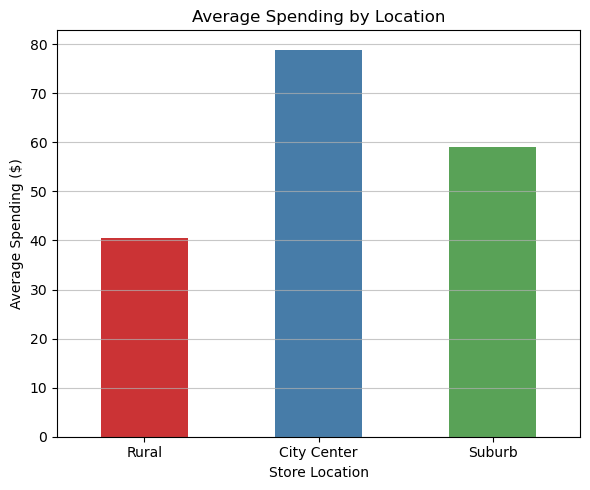

In [80]:
# Calculate effect sizes - contrast with MDE
# Gemini generated for a cleaner generalized solution
# Spending Across Locations - Comparing for a 15% difference in location pair means
city_avg_spend = data[data["Store_Location"] == "City Center"]["Amount_Spent"].mean()
suburb_avg_spend = data[data["Store_Location"] == "Suburb"]["Amount_Spent"].mean()
rural_avg_spend = data[data["Store_Location"] == "Rural"]["Amount_Spent"].mean()

location_means = {
    "City Center": city_avg_spend,
    "Suburb": suburb_avg_spend,
    "Rural": rural_avg_spend,
}

print("Spending Differences Compared to MDE (15%):")

for loc1, loc2 in combinations(location_means.keys(), 2):
    mean1 = location_means[loc1]
    mean2 = location_means[loc2]
    percentage_difference = abs((mean1 - mean2) / mean2) * 100

    direction = ""
    if mean1 > mean2:
        direction = f"{loc1} is {(percentage_difference):.2f}% higher than {loc2}"
    elif mean2 > mean1:
        direction = f"{loc2} is {(percentage_difference):.2f}% higher than {loc1}"
    else:
        direction = f"{loc1} and {loc2} have the same average spending"

    print(f"{loc1}/{loc2}: {direction}")
    if percentage_difference >= 15:
        print("  Greater than/equal to MDE")
    else:
        print("  Less than MDE")

# Calculate average spending per location
avg_spending = data.groupby("Store_Location")["Amount_Spent"].mean().reset_index(name="Average_Spending")

# --- Bar Chart for Average Spending ---
plt.figure(figsize=(6, 5))
sns.barplot(x="Store_Location", y="Average_Spending", data=avg_spending,
            hue="Store_Location", palette=location_colors, order=location_order, legend=False, width=0.5)
plt.title("Average Spending by Location")
plt.xlabel("Store Location")
plt.ylabel("Average Spending ($)")
plt.grid(axis="y", alpha=0.7)
plt.tight_layout()
plt.show()

Customer Satisfaction Differences Compared to MDE (1.0 point):
City Center/Suburb: City Center has a 1.00 point higher median rating than Suburb
  Greater than/equal to MDE
City Center/Rural: City Center has a 2.00 point higher median rating than Rural
  Greater than/equal to MDE
Suburb/Rural: Suburb has a 1.00 point higher median rating than Rural
  Greater than/equal to MDE


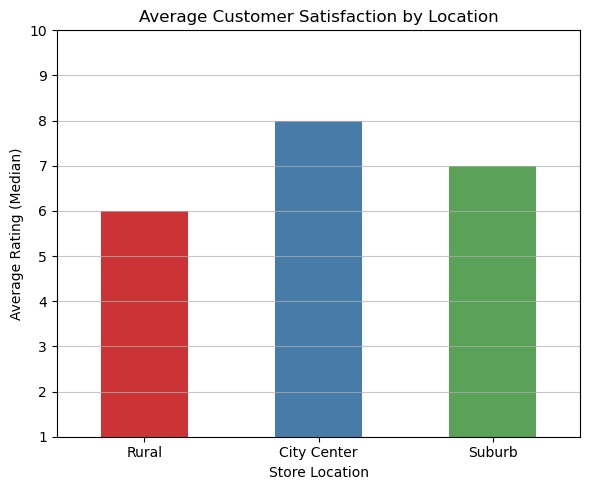

In [81]:
# Ratings Across Locations - Comparing for a 1.0 difference in location pair *medians*
city_median_rating = data[data["Store_Location"] == "City Center"]["Customer_Satisfaction"].median()
suburb_median_rating = data[data["Store_Location"] == "Suburb"]["Customer_Satisfaction"].median()
rural_median_rating = data[data["Store_Location"] == "Rural"]["Customer_Satisfaction"].median()

location_medians = {
    "City Center": city_median_rating,
    "Suburb": suburb_median_rating,
    "Rural": rural_median_rating,
}

print("Customer Satisfaction Differences Compared to MDE (1.0 point):")

for loc1, loc2 in combinations(location_medians.keys(), 2):
    median1 = location_medians[loc1]
    median2 = location_medians[loc2]
    absolute_difference = abs(median1 - median2)

    direction = ""
    if median1 > median2:
        direction = f"{loc1} has a {absolute_difference:.2f} point higher median rating than {loc2}"
    elif median2 > median1:
        direction = f"{loc2} has a {absolute_difference:.2f} point higher median rating than {loc1}"
    else:
        direction = f"{loc1} and {loc2} have the same median rating ({median1:.2f})"  # Added median value

    print(f"{loc1}/{loc2}: {direction}")
    if absolute_difference >= 1.0:
        print("  Greater than/equal to MDE")
    else:
        print("  Less than MDE")

# Bar Chart for Average Ratings
avg_ratings_df = pd.DataFrame(location_medians.items(), columns=['Store_Location', 'Average_Rating'])
avg_ratings_df['Store_Location'] = pd.Categorical(avg_ratings_df['Store_Location'], categories=["Rural", "City Center", "Suburb"], ordered=True)

plt.figure(figsize=(6, 5))
sns.barplot(x="Store_Location", y="Average_Rating", data=avg_ratings_df.sort_values('Store_Location'),
            hue="Store_Location", palette=location_colors, legend=False, width=0.5, order=location_order)
plt.title("Average Customer Satisfaction by Location")
plt.xlabel("Store Location")
plt.ylabel("Average Rating (Median)")
plt.ylim(1, 10)  # Adjust y-axis limits to the 1-10 scale
plt.grid(axis="y", alpha=0.7)
plt.tight_layout()
plt.show()

Promotional spending is 0.42% higher than non-promotional spending
This is substantially lower than our target MDE of 15%


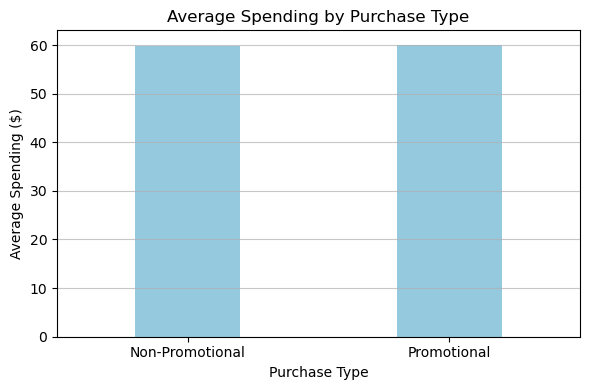

In [82]:
# Promotional Spending
promo_mean_spend = data[data["Purchase_Type"] == "Promotional"]["Amount_Spent"].mean()
nonpromo_mean_spend = data[data["Purchase_Type"] == "Non-Promotional"]["Amount_Spent"].mean()
type_mean_ratio = promo_mean_spend / nonpromo_mean_spend
print(f"Promotional spending is {(type_mean_ratio - 1) * 100:.2f}% higher than non-promotional spending")
print("This is substantially lower than our target MDE of 15%")

# Bar Chart

plt.figure(figsize=(6, 4))
sns.barplot(x=["Non-Promotional", "Promotional"], y=[nonpromo_mean_spend, promo_mean_spend], color="skyblue", width=0.4)
plt.title("Average Spending by Purchase Type")
plt.xlabel("Purchase Type")
plt.ylabel("Average Spending ($)")
plt.grid(axis="y", alpha=0.7)
plt.tight_layout()
plt.show()

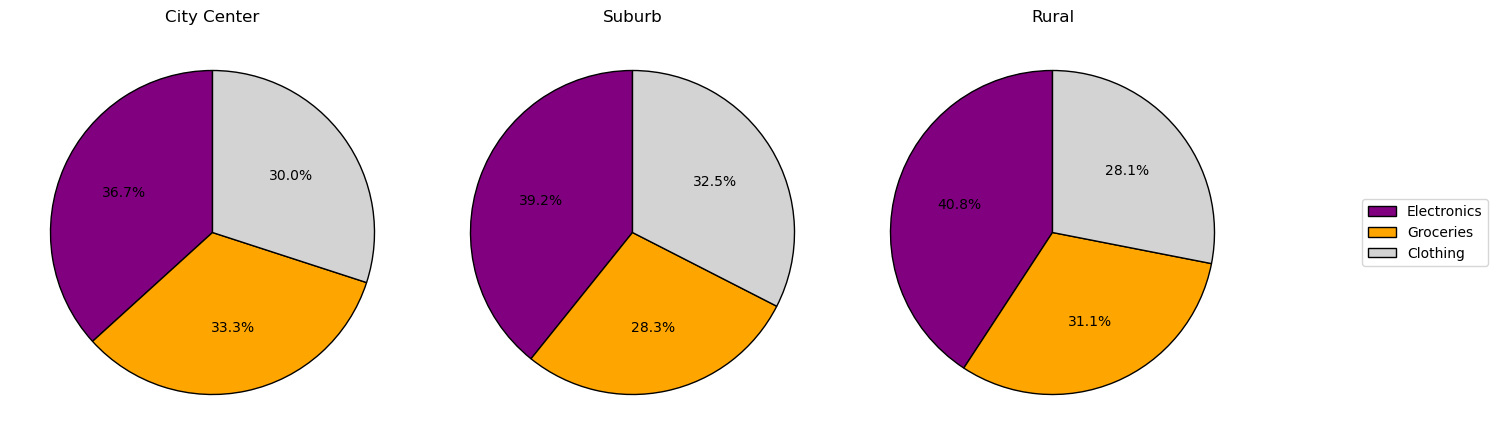

In [83]:
# Define the custom colors and categories
categories = ["Electronics", "Groceries", "Clothing"]

# Function to create a pie chart for a given location
def create_pie_chart(ax, location_data, title):
    """
    Creates a pie chart for the product category distribution at a specific location.

    Parameters:
        ax (matplotlib.axes._subplots.AxesSubplot): The subplot axes to draw the pie chart on.
        location_data (pandas.DataFrame): DataFrame containing the product category data for the location.
        title (str): The title of the pie chart.
    """

    # 1. Calculate category counts for the given location:
    category_counts = location_data["Product_Category"].value_counts()

    # 2. Ensure that the counts are in the correct order:
    category_counts = category_counts.reindex(categories, fill_value=0)

    # 3. Create the pie chart on the provided axes
    pie_chart = ax.pie(
        category_counts,
        autopct="%1.1f%%",
        startangle=90,
        wedgeprops={"edgecolor": "black"},
        colors=product_colors,
    )
    ax.set_title(title)

    # Remove the labels from the pie slices, and instead create a single legend
    # outside the charts.
    return pie_chart # return the pie chart object so we can create a single legend.

# Create the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Create the pie charts for each location, handling potential errors:

location_city_center_data = data[data["Store_Location"] == "City Center"]
pie_chart_city_center = create_pie_chart(axes[0], location_city_center_data, "City Center")

location_suburb_data = data[data["Store_Location"] == "Suburb"]
pie_chart_suburb = create_pie_chart(axes[1], location_suburb_data, "Suburb")

location_rural_data = data[data["Store_Location"] == "Rural"]
pie_chart_rural = create_pie_chart(axes[2], location_rural_data, "Rural")

# Add a single legend to the figure, using any of the pie chart objects.
# But only add the legend if there is a valid pie chart.
if pie_chart_city_center: # Check if pie_chart_city_center is not None
    fig.legend(pie_chart_city_center[0],  # The wedges.
               categories,             # The category names
               loc="center right",      # Position the legend
               bbox_to_anchor=(1, 0.5))  # Fine-tune the position

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Make space for the legend
plt.show()

**Reflective Question: Results - Clearly state whether the null hypotheses were rejected or not. Frame this in the business question context. Use effect sizes (e.g., Cohen’s d, eta squared) to contextualize the significance of your results.**

1. Spending across locations - with p = 0.00 (source: Welch's ANOVA) we can reject the null hypothesis that there is no average spending difference across locations. The effect size of 0.649 (64.9%, partial eta-squared) clearly shows that store location is strongly correlated with average spending. Our MDE was a 15% absolute difference between stores. Given that the smallest percentage difference is 33% (City Center and Suburb), this result is practically significant to the business, and can be used to inform location-specific strategies on issues such as staffing and inventory. Post-hoc testing using Games-Howell revealed high confidence (all p = 0.00) that individual location pairs have statistically different mean spending as well (this aligns well with our extremely low Welch's p-value and high effect size).

2. Satisfaction ratings across locations - with p = 0.00 (source: Kruskal-Wallis) we can reject the null hypothesis that there is no median rating difference across locations. The effect size of 0.24 (24%, eta-squared) shows that store location is strongly correlated with median ratings. The effect magnitude of 1.0 between City Center/Suburb and Suburb/Rural is right at our MDE threshold of 1.0, with City Center/Rural having a 2.0 gap. The Dunn's post-hoc test shows with p = 0.00 that all location pairs tested show statistically significant differences as well. This result is practically significant to the business and can be used to inform decision-making.

3. Promotional spending - with p = 0.34 (source: Mann-Whitney U) we fail to reject the null hypothesis that there is no average spending difference between promotional and non-promotional purchases. This is intuitive with our observed magnitude of a 0.42% difference, which falls substantially below our MDE of 15%. This result is neither statistically significant nor practically significant to the business.

4. Product category preferences across locations - with p = 0.31 (source: Chi-square Homogeneity) we fail to reject the null hypothesis that the popularity of different product categories is the same regardless of the store location. Post-hoc testing on location pairs using Dunn's test also did not suggest variation (lowest p = 0.37). This result is not statistically significant to the business.

**Reflective Question: Recommendations - Explain the practical implications of the results. What should the company do based on your findings about spending, satisfaction, or product preferences?**

#### Spending Across Locations

With an effect size of 65% we can conclude that there are substantial differences in average spending by location. We should be cautious in directly making decisions about staffing and inventory from this metric, but it indicates an excellent opportunity for further analysis. For example, our per capita labor and per square foot real estate costs may be lower for the Rural location. The "warehouse space" would likely be different as well, so it is likely easier for the Rural location to hold onto a larger amount of inventory. It might be tempting to conclude we should move more inventory to the City Center location because of this higher average spend, but we would need to take into account the costs of storing that inventory. Further analysis taking into account these factors (costs, total spending) is needed before making major decisions.

To specifically address average spending, we could also consider "exit surveys" of customers who do not appear to have purchased much. It is common practice for cashiers to ask, "Did you find everything you were looking for?" However, this question can become routine and customers may just say "Sure" even if they did not find something they wanted. We could investigate training options for cashiers at locations with lower average spends to make sure to ask this question. Even something as simple as attempting to make direct eye contact with the customer when asking could lead to substantially higher rates of honest feedback. Managers should encourage cashiers to report this feedback, and then act on those reports. Lastly, we could consider the effects of automated checkout, where there is limited opportunity for this feedback.

#### Satisfaction Ratings Across Locations

The median differences between City/Suburb and Suburb/Rural are right at our MDE threshold of 1.0, with the City/Rural difference being more pronounced (2.0). This indicates a potential for customer service improvement, particular in the Rural location. 

Location as a confounding factor - keep in mind that we cannot treat one location as a "control" for another. It may be that the Rural population just has a tendency to leave lower ratings for all stores compared to the City/Suburb population. To account for this confounding factor, we could compare publicly available ratings data such as Yelp or Google Maps reviews for other businesses. If the Rural region shows lower ratings across many stores compared to the City region, this should be taken into account when analyzing satisfaction scores. 

Detailed customer feedback - if it can be gathered, this would be ideal. *Why* are customers less satisfied (problems with auto checkout, unfriendly cashiers, not enough help finding things, poor store layout, etc.).

Employee surveys and crossing - ask all employees (management and non-management) to complete an anonymous survey on customer experience. What do *they* think their location is doing well/poorly in terms of customer service? Depending on the feasability, we could also consider scheduling trips for managers from one location to visit another to see differences up close. Lastly, ensuring management of different locations have an "open channel" to discuss ideas for improvements could be beneficial if this is not already in place.

#### Promotional Spending

Given the incredibly small increase of 0.42%, we are nowhere near the target of 15%. There are several approaches the business could take here. The simplest is to stop offering promotions entirely, given this poor ROI. Here are some approaches to consider for promotions going forward:

Discount magnitude/mechanism - shift from a 25% discount (e.g.) to a "buy one get one half off" model. While the total discount remains the same (0.75 + 0.75 = 1.5) the customer can only realize the discount by purchasing more items.

Store signage - We could examine whether signage in the store is clearly communicating the discounts and encouraging larger purchases. If a customer does not know the item is 25% off until they get to the register, this is effectively a loss. If an issue is found, this could be addressed immediately.

Supplier partnerships - investigate partnerships with our suppliers. If a particular supplier wants to "push" their products, they may be willing to offer us a discount, leading to a higher ROI.

Total spending angle - shift to considering total spending for a given period compared with historical averages. Promotions may add value by bringing more customers into the store, even if individual customers do not substantially purchase more items. This approach would be boosted by coordinating with the Marketing team to better advertise our promotions.

Other potential benefits - adjust our expectations for the effect on spending if we believe promotions are valuable for some other reason (increased customer satisfaction, competition with other stores).

Lastly, we should keep in mind that there is a "hidden effect" that depends on the magnitude of the discount. For example, if every item in the store is 50% off during a promotional period, but overall spending remains steady, customers actually are purchasing twice as much. This doesn't do anything positive for our bottom line, but we should not conclude that promotions "have no effect".

#### Product Preferences Across Locations

Our analysis did not find any significant differences between product category proportions between locations. If we have particular reason to believe there are useful differences to be found at a more granular level, we could break our existing categories into sub-categories (for example "Clothing" could have sub-categories for Men, Women, and Children), or even investigate the frequency of specific products at the SKU level. 

### Part 5: Reflection

Discuss:
1. The strengths and limitations of your analysis
2. Any assumptions or potential biases in the data
3. Suggestions for additional data collection
4. How this analysis could be improved

**Reflective Question: Explain the importance of experimental design and sufficient sample size in conducting a robust analysis. Identify any limitations in the dataset or analysis (e.g., potential biases, unmeasured variables) and suggest additional data the company could collect to improve future analyses.**

#### Experimental Design

Solid experimental design is crucial to producing sound results in the same way the foundation of a house is crucial for building the structure. We want to choose an appropriate alpha to limit the chances of making either a Type I or Type II error. Clearly defined and measurable goals inform the analysis. "Here's some data - what do you think we should do?" is an approach that is likely to waste time and produce results that are not useful to the business.

Sample size has a large impact on the confidence of our results. In this case, our sample size of 1500 is large enough that **if** the sample is representative, we can be confident in our conclusions.

#### Strengths

My analysis used appropriate pre-testing (Shapiro, Levene) to confirm assumptions about what type of tests to run, and selected tests based on these findings (Welch's ANOVA, Kruskal-Wallis, etc.). Where appropriate, I followed up with post-hoc tests to look at the data in more detail.

I carefully considered the implications of the p-values and effect sizes and clearly communicated these numbers in my findings. I believe my final recommendations offered some thoughtful options and were well-supported by the available data. I used reasonable good visualizations to both inform my analysis and visually convey the data.

#### Limitations

Lack of business interface and domain knowledge - due to the fact that this is an educational exercise, I was unable to ask clarifying questions and was forced to make some assumptions - for example, that median satisfaction ratings would be a good choice. Similarly, since there are no actual stores for me to visit, I was limited to the implications of the data set. This domain knowledge, or lack thereof, informs the final analysis in particular. I was forced to make a wider range of guesses, and unable to "zero in" on ideas that are more likely to be helpful suggestions.

Location as a confounding factor - discussed previously, this is a huge potential factor in our comparisons of different locations, particularly for satisfaction ratings, but also potentially for spending and product category analysis.

Forced to trust the data - obviously there's a "garbage in garbage out" factor. Even if the data is correct, is it a good typical representation? If this data came from the week before Christmas, that would color my interpretation substantially, and I would advise extreme caution in extrapolating these results to the rest of the year.

#### Assumptions and Biases

My analysis implicitly assumes that the data is recorded accurately and is reasonably representative. If the data was collected on a voluntary basis, this would overrepresent customers with strong opinions (positive or negative). Given that we have ratings data for every transaction, we must conclude some degree of selection bias, as a store cannot in practice force customers to rate their experience.

User satisfaction surveys may also be biased by customers not wanting to be seen as "whiners", or perhaps even the reverse effect - a belief that leaving a negative rating would lead to a manager offering them a discount. This would depend on the manner in which this data is collected.

Several of the tests assume independence. This type of data can never be truly independent, but for example if one irritated customer made many small individual purchases (seems unlikely, but possible) and left many negative ratings, this would violate the independence assumption. Conversely, if a manager at one of the locations asks their friends to make a lot of purchases and leave higher ratings, this would also skew the data.

The product categories are also problematic. If a customer comes to the checkout counter with both groceries and clothing (an extremely likely occurence), how is the category recorded - the first item run up, the count of items, the proportion of the purchase? 

#### Additional Data Collection

To extend this data set, we could include purchase data for customers who did not choose to leave a rating. This would reduce or eliminate the selection bias in that respect. Similarly, we could reduce the bias towards data from transactions by surveying customers who did not purchase anything. This may sound impractical, but this method was used by The Home Depot when they started their first stores.

Customer satisfaction - data on other similar stores in the area to analyze location as a confounding variable; more granular customer ratings (for example rating checkout experience, store layout, product selection/pricing separately)

Product categories - more granularity, such as sub-categories like DVDs, gaming systems, computer accessories for Electronics. Or, even more granular by getting specific SKU lists.